In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/1111111/val/0/img_40.png
/kaggle/input/1111111/val/0/img_27.png
/kaggle/input/1111111/val/0/img_18.png
/kaggle/input/1111111/val/0/img_31.png
/kaggle/input/1111111/val/0/img_47.png
/kaggle/input/1111111/val/0/img_50.png
/kaggle/input/1111111/val/0/img_28.png
/kaggle/input/1111111/val/0/img_10.png
/kaggle/input/1111111/val/0/img_23.png
/kaggle/input/1111111/val/0/img_6.png
/kaggle/input/1111111/val/0/img_34.png
/kaggle/input/1111111/val/0/img_26.png
/kaggle/input/1111111/val/0/img_15.png
/kaggle/input/1111111/val/0/img_12.png
/kaggle/input/1111111/val/0/img_13.png
/kaggle/input/1111111/val/0/img_8.png
/kaggle/input/1111111/val/1/img_16.png
/kaggle/input/1111111/val/1/img_38.png
/kaggle/input/1111111/val/1/img_20.png
/kaggle/input/1111111/val/1/img_2.png
/kaggle/input/1111111/val/1/img_37.png
/kaggle/input/1111111/val/1/img_1.png
/kaggle/input/1111111/val/1/img_32.png
/kaggle/input/1111111/val/1/img_39.png
/kaggle/input/1111111/val/1/img_43.png
/kaggle/input/1111111/val/1/i

 # IMPORT LIBRARIES # 

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.datasets as datasets
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


In [6]:
# ✅ Define dataset paths
DATASET_PATH = "/kaggle/input/1111111/"
train_dir = DATASET_PATH + "train"
val_dir = DATASET_PATH + "val"
test_dir = DATASET_PATH + "test"

# ✅ Load Dataset (No Augmentation or Preprocessing)
train_dataset = datasets.ImageFolder(root=train_dir)
val_dataset = datasets.ImageFolder(root=val_dir)
test_dataset = datasets.ImageFolder(root=test_dir)

# ✅ Create Dataloaders (Batch Size Testing 8 & 16)
batch_size = 8  
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [7]:
# ✅ Load Pretrained ResNet18
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Binary classification (NORMAL vs SICK)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


In [9]:
import torchvision.transforms as transforms

# ✅ Define Transform (Convert PIL Image to Tensor)
transform = transforms.Compose([
    transforms.ToTensor()  # Convert PIL Image to Tensor
])

# ✅ Load Dataset with Transform
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# ✅ Create DataLoader
batch_size = 8  
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [10]:
# ✅ Define loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)  # Increased LR
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)

# ✅ Early Stopping
early_stopping_patience = 5
best_val_loss = float("inf")
epochs_no_improve = 0

# ✅ Track metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# 🚀 Training Loop
num_epochs = 50
print("Starting Training...")

for epoch in range(num_epochs):
    start_time = time.time()
    
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "/kaggle/working/best_model.pth")  # Save best model
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve >= early_stopping_patience:
        print(" Early stopping triggered.")
        break

    scheduler.step(val_loss)
    end_time = time.time()
    latency = end_time - start_time

    print(f"✅ Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Time: {latency:.2f}s")

print(" Training complete!")


Starting Training...


Epoch 1/50 [Validation]: 100%|██████████| 7/7 [00:00<00:00, 29.27it/s]


✅ Epoch 1: Train Loss: 1.1675, Train Acc: 0.6433, Val Loss: 1.3904, Val Acc: 0.6923, Time: 2.41s


Epoch 2/50 [Validation]: 100%|██████████| 7/7 [00:00<00:00, 69.98it/s]


✅ Epoch 2: Train Loss: 0.5095, Train Acc: 0.7834, Val Loss: 0.3962, Val Acc: 0.8077, Time: 0.81s


Epoch 3/50 [Validation]: 100%|██████████| 7/7 [00:00<00:00, 61.53it/s]


✅ Epoch 3: Train Loss: 0.4668, Train Acc: 0.7707, Val Loss: 0.7628, Val Acc: 0.5769, Time: 0.72s


Epoch 4/50 [Validation]: 100%|██████████| 7/7 [00:00<00:00, 52.41it/s]


✅ Epoch 4: Train Loss: 0.4745, Train Acc: 0.8344, Val Loss: 2.8386, Val Acc: 0.6923, Time: 0.75s


Epoch 5/50 [Validation]: 100%|██████████| 7/7 [00:00<00:00, 65.18it/s]


✅ Epoch 5: Train Loss: 0.5889, Train Acc: 0.8025, Val Loss: 0.6233, Val Acc: 0.8846, Time: 0.68s


Epoch 6/50 [Validation]: 100%|██████████| 7/7 [00:00<00:00, 70.51it/s]


✅ Epoch 6: Train Loss: 0.3779, Train Acc: 0.8599, Val Loss: 0.2727, Val Acc: 0.9231, Time: 0.76s


Epoch 7/50 [Validation]: 100%|██████████| 7/7 [00:00<00:00, 70.06it/s]


✅ Epoch 7: Train Loss: 0.3437, Train Acc: 0.8790, Val Loss: 0.3671, Val Acc: 0.8269, Time: 0.63s


Epoch 8/50 [Validation]: 100%|██████████| 7/7 [00:00<00:00, 75.32it/s]


✅ Epoch 8: Train Loss: 0.2868, Train Acc: 0.9108, Val Loss: 0.3248, Val Acc: 0.8462, Time: 0.63s


Epoch 9/50 [Validation]: 100%|██████████| 7/7 [00:00<00:00, 66.14it/s]


✅ Epoch 9: Train Loss: 0.2378, Train Acc: 0.9299, Val Loss: 0.3539, Val Acc: 0.8269, Time: 0.64s


Epoch 10/50 [Validation]: 100%|██████████| 7/7 [00:00<00:00, 76.08it/s]


✅ Epoch 10: Train Loss: 0.1754, Train Acc: 0.9554, Val Loss: 0.4932, Val Acc: 0.7885, Time: 0.64s


Epoch 11/50 [Validation]: 100%|██████████| 7/7 [00:00<00:00, 71.98it/s]


✅ Epoch 11: Train Loss: 0.2120, Train Acc: 0.9045, Val Loss: 0.2087, Val Acc: 0.8846, Time: 0.73s


Epoch 12/50 [Validation]: 100%|██████████| 7/7 [00:00<00:00, 75.74it/s]


✅ Epoch 12: Train Loss: 0.1458, Train Acc: 0.9745, Val Loss: 0.2228, Val Acc: 0.8846, Time: 0.62s


Epoch 13/50 [Validation]: 100%|██████████| 7/7 [00:00<00:00, 74.18it/s]


✅ Epoch 13: Train Loss: 0.1120, Train Acc: 0.9745, Val Loss: 0.3526, Val Acc: 0.8462, Time: 0.63s


Epoch 14/50 [Validation]: 100%|██████████| 7/7 [00:00<00:00, 74.99it/s]


✅ Epoch 14: Train Loss: 0.1173, Train Acc: 0.9618, Val Loss: 0.3447, Val Acc: 0.8462, Time: 0.64s


Epoch 15/50 [Validation]: 100%|██████████| 7/7 [00:00<00:00, 73.44it/s]


✅ Epoch 15: Train Loss: 0.0948, Train Acc: 0.9618, Val Loss: 0.4135, Val Acc: 0.8269, Time: 0.60s


Epoch 16/50 [Validation]: 100%|██████████| 7/7 [00:00<00:00, 76.44it/s]

 Early stopping triggered.
 Training complete!


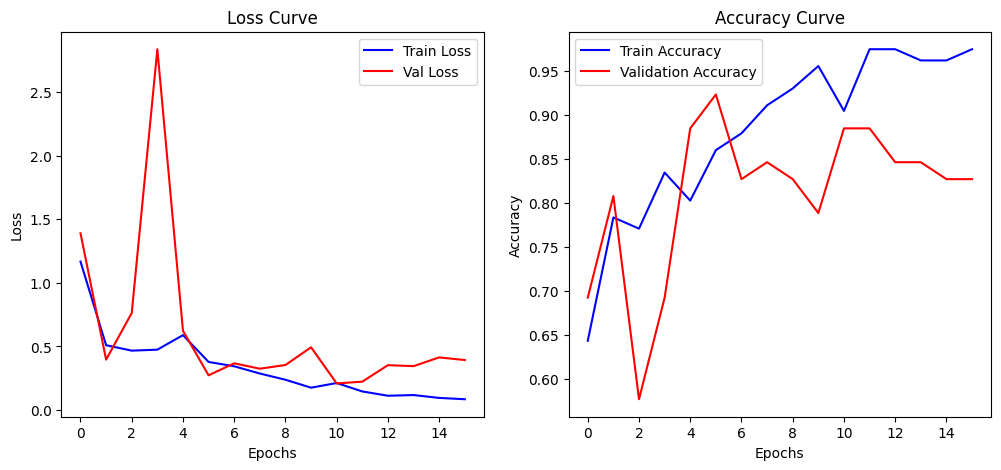

In [11]:
# ✅ Loss & Accuracy Plots
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss", color='blue')
plt.plot(val_losses, label="Val Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy", color='blue')
plt.plot(val_accuracies, label="Validation Accuracy", color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()


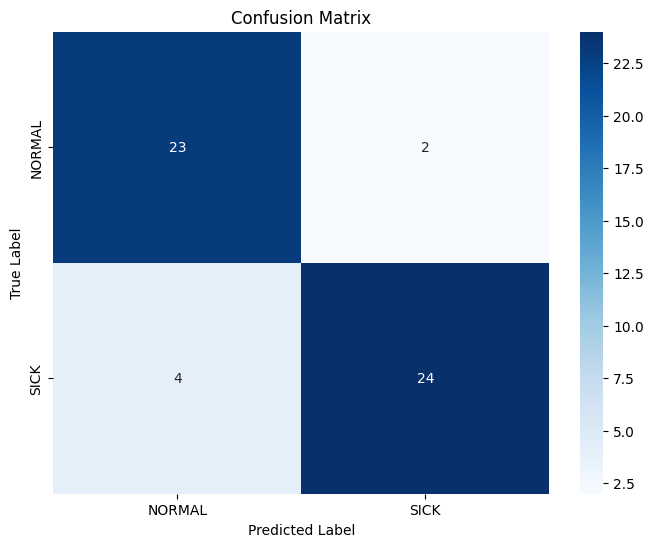

In [16]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ✅ Function to compute predictions
def get_predictions(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# ✅ Generate Confusion Matrix
def plot_confusion_matrix(model, dataloader, class_names):
    y_true, y_pred = get_predictions(model, dataloader)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# ✅ Run Confusion Matrix
class_names = ["NORMAL", "SICK"]  # Update based on your dataset
plot_confusion_matrix(model, test_loader, class_names)
